# 任务一 CNN手绘图像分类

## 1.1 读入图像并展示
1. 每类展示10个样本图像
2. 将‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’ 7个类的数据，每类按照7:2:1划分为“训练集”、“验证集”和“分布内测试集（IN-test）”
3. 将‘foot’,‘owl’,‘pig‘作为“分布外数据集”，每类抽取100张图像构成“分布外测试数据集（OOD-test）

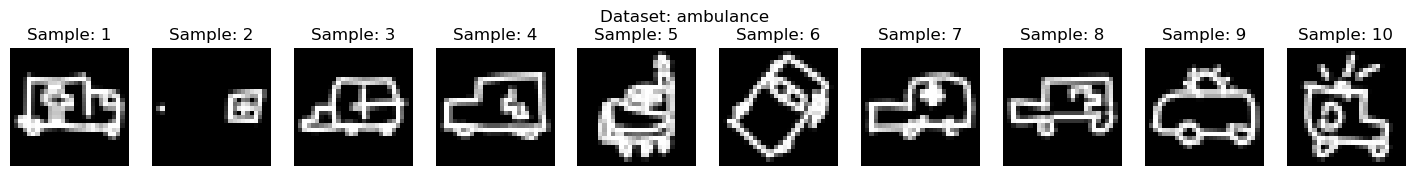

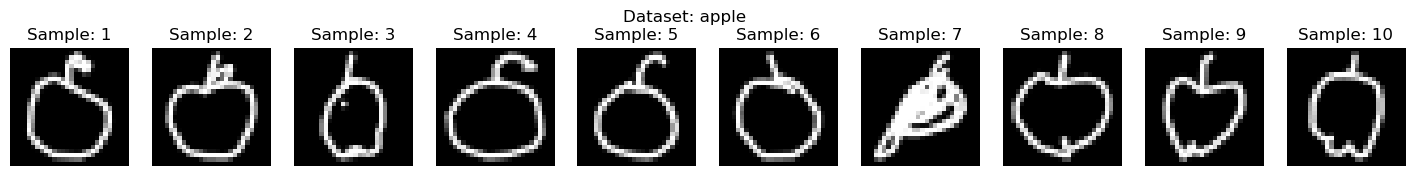

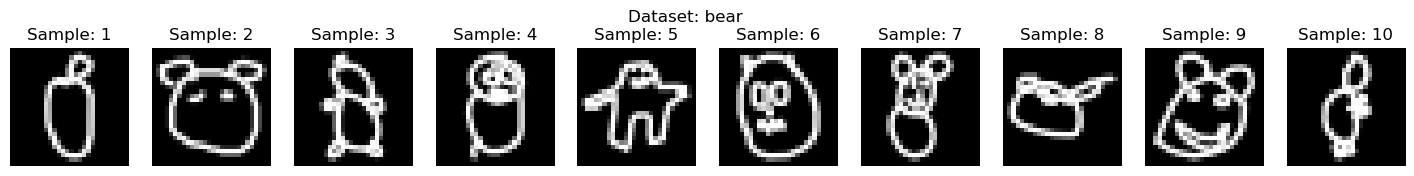

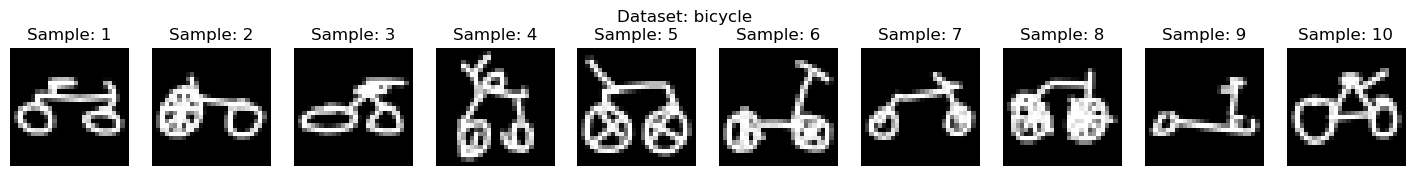

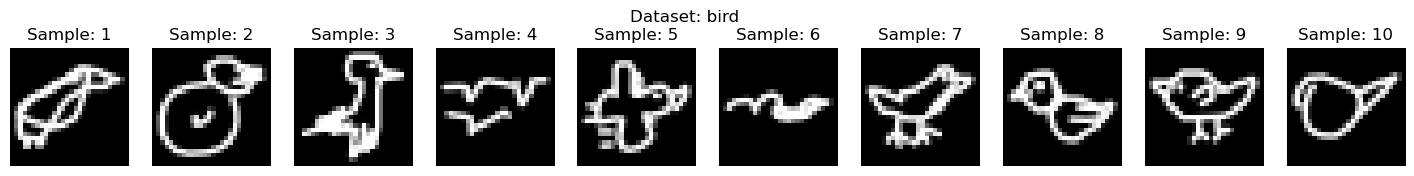

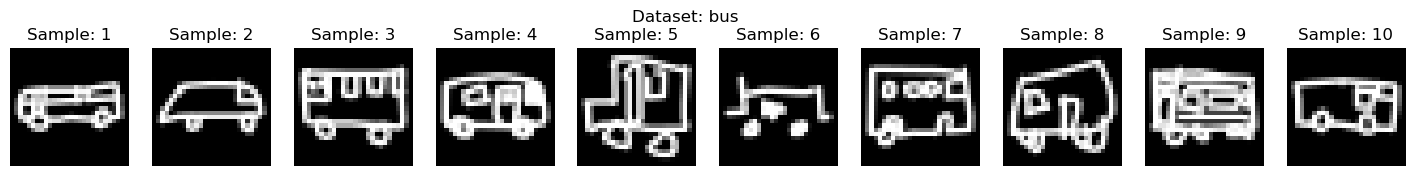

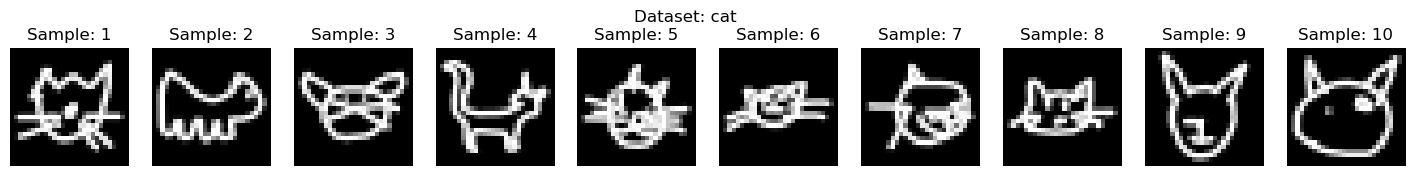

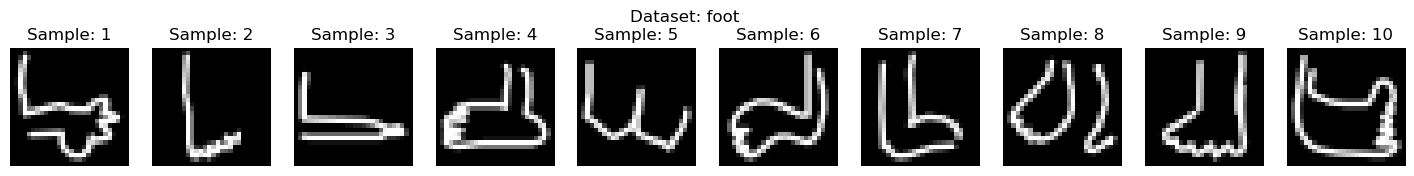

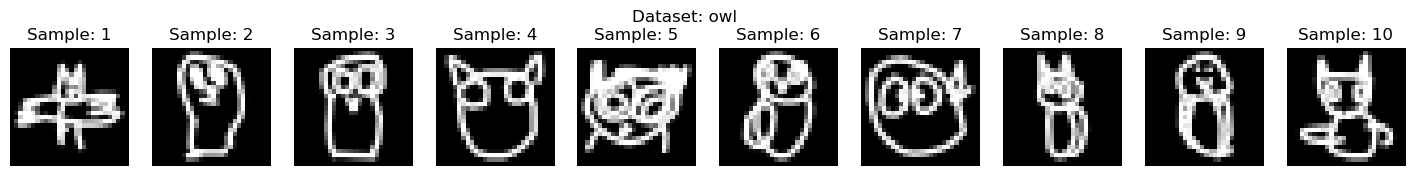

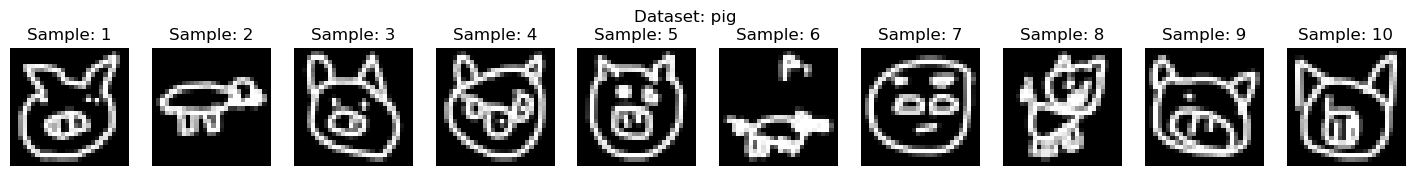

In [14]:
import numpy as np
import matplotlib.pyplot as plt


def read_and_show_data(path, dataset_name, show_num):
    file = np.load(path + '/' + dataset_name + '/' + dataset_name + '.npy')

    # 从数组中随机抽取元素的索引
    random_indices = np.random.choice(len(file), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices]  

    # 绘图
    plt.figure(figsize=(18, 2))
    for i in range(show_num):
        plt.subplot(1, 10, i + 1) 

        image = random_samples[i].reshape(28, 28)

        plt.imshow(image, cmap='gray')
        plt.title(f"Sample: {i+1}")
        plt.axis('off')

    plt.suptitle(f"Dataset: {dataset_name}")
    plt.show()

    # 每张图片数据reshape
    data = []
    for pic in file:
        data.append(pic.reshape(1,28,28)) # channel，height，width
    

    return np.array(data) # 使用np数组

# 标签定义
# ‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’,‘foot’,‘owl’,‘pig‘
label = {'ambulance':0, 'apple':1, 'bear':2, 'bicycle':3, 'bird':4, 'bus':5, 'cat':6, 'foot':7, 'owl':8, 'pig':9}

all_data = []

all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'ambulance', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'apple', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bear', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bicycle', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bird', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bus', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'cat', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'foot', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'owl', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'pig', 10))

# numsample，channel，height，width
all_data = np.array(all_data) # 转为np数组


为了使用torch提供的dataloader，需要自定义一个dataset类。

In [15]:
# 生成可用的数据集
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        label = self.labels[index]

        return data, label


train_x = []
train_y = []
val_x = []
val_y = []
test_x_in = []
test_y_in = []
test_x_out = []
test_y_out = []

# 在原数据集中进行分割，输出list
for i in range(all_data.shape[0]):
    total_length = all_data[i].shape[0]

    # 分布外数据集
    if i >= 7:
        random_indices = np.random.choice(all_data[i].shape[0], 100, replace=False) # 每类抽取100张图像构成分布外测试数据集
        random_samples = all_data[i][random_indices] 

        test_x_out.extend(random_samples)
        test_y_out.extend([i]*100)

    # 分布内数据集
    else:
        split1 = int(total_length * 0.7)
        split2 = int(total_length * 0.9)

        train_x.extend(all_data[i][:split1])
        train_y.extend([i]*split1)
        val_x.extend(all_data[i][split1:split2])
        val_y.extend([i]*(split2-split1))
        test_x_in.extend(all_data[i][split2:])
        test_y_in.extend([i]*(total_length - split2))


train_data = MyDataset(train_x,train_y)
val_data = MyDataset(val_x,val_y)
test_data_in = MyDataset(test_x_in,test_y_in)
test_data_out = MyDataset(test_x_out,test_y_out)

## 1.2 使用pytorch搭建网络

In [16]:
from turtle import forward
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


# 构建LeNet模型
class LeNet(nn.Module):
    def __init__(self):
        # 一个通道，10个分类
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2) # 1*28*28 -> 6*28*28
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x)))
        x = self.pool(torch.sigmoid(self.conv2(x)))
        x = x.flatten(1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
    

# 构建GoogleLeNet
# Inception块
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1*1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1*1卷积层后接3*3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1*1卷积层后接5*5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3*3最大池化层后接1*1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = torch.relu(self.p1_1(x))
        p2 = torch.relu(self.p2_2(torch.relu(self.p2_1(x))))
        p3 = torch.relu(self.p3_2(torch.relu(self.p3_1(x))))
        p4 = torch.relu(self.p4_2(self.p4_1(x)))
        # 在通道维上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)
    
# GoogleLeNet模型
class GoogleLeNet(nn.Module):
    def __init__(self):
        super(GoogleLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception3a = Inception(192, 64, (96, 128), (16, 32), 32)
        self.inception3b = Inception(256, 128, (128, 192), (32, 96), 64)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, (96, 208), (16, 48), 64)
        self.inception4b = Inception(512, 160, (112, 224), (24, 64), 64)
        self.inception4c = Inception(512, 128, (128, 256), (24, 64), 64)
        self.inception4d = Inception(512, 112, (144, 288), (32, 64), 64)
        self.inception4e = Inception(528, 256, (160, 320), (32, 128), 128)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, (160, 320), (32, 128), 128)
        self.inception5b = Inception(832, 384, (192, 384), (48, 128), 128)
        self.pool5 = nn.AdaptiveAvgPool2d((1, 1))

        self.liner1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)

        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.pool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.pool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.pool5(x)
        x = x.flatten(1)

        return self.liner1(x)



## 1.3模型训练与验证

In [17]:
import time

# 打印与轮次有关的信息（acc、loss）
def show_info(epochs, acc_list, loss_list, val_acc_list, val_loss_list):
    plt.figure(figsize=(16, 4))
    
    plt.suptitle("Acc and Loss in each epoch")
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, epochs + 1, dtype=int), acc_list, label='acc')
    plt.plot(np.arange(1, epochs + 1, dtype=int), val_acc_list, label='val_acc')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, epochs + 1, dtype=int), loss_list, label='loss')
    plt.plot(np.arange(1, epochs+1, dtype=int), val_loss_list, label='val_loss')
    plt.legend()


    plt.show()

# 绘图展示结果概率分布
def show_result(path, dataset_name, y_hat, show_num = 10):
    file = np.load(path + '/' + dataset_name + '/' + dataset_name + '.npy')

    # 从数组中随机抽取元素的索引
    random_indices = np.random.choice(len(y_hat), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices]  
    random_result = nn.functional.softmax(y_hat, dim=1)[random_indices] # 转换为概率

    # 绘图
    plt.figure(figsize=(22, 3))
    for i in range(show_num):
        # 实际手绘图像
        plt.subplot(1, 10, i + 1) 
        image = random_samples[i].reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.title(f"Sample: {i+1}")
        plt.axis('off')

    plt.suptitle(f"Picture of samples: {dataset_name} with id {label[dataset_name]}")
    plt.show()

    # 概率条形图
    plt.figure(figsize=(22,3))
    for i in range(show_num):
        plt.subplot(1, 10, i + 1) 
        plt.ylim(0, 1, 0.1)
        plt.xticks(range(10))
        plt.bar([0,1,2,3,4,5,6,7,8,9], random_result[i])
        plt.title(f"Sample {i+1} Predict")
    
    plt.show()



In [18]:
# 使用倒入的数据进行训练，最终将模型保存为文件
def train(model, device, learning_rate, num_epochs, batch_size, train_data, val_data):
    # 定义损失函数和优化器
    CE = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练模型
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # 尝试多个batch_size训练

    # 模型选择
    val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
    best_val_loss = float('inf')
    best_model = model
    best_epoch = 0
    best_val_loss = 99999999


    running_loss = [] #记录loss变化
    valling_loss = [] #记录val_loss变化
    start_time = time.time() # 记时
    train_acc_list = [] # 记录训练acc变化
    val_acc_list = []
    for epoch in range(num_epochs):
        running_loss.append(0.0)
        acc = 0

        model.to(device)

        # 训练
        model.train()
        for x, y in train_loader:
            x = x.float().to(device)
            y = y.long().to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            
            loss = CE(y_hat, y)
            loss.backward()
            optimizer.step()

            running_loss[epoch] += loss.item()

            # acc记录
            acc += torch.sum(torch.max(y_hat, 1)[1] == y).item()

        # 验证与选优（记录acc）
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0
            for x_val, y_val in val_loader:
                x_val = x_val.float().to(device)
                y_val = y_val.long().to(device)

                y_val_hat = model(x_val)
                val_loss += CE(y_val_hat, y_val).item()

                val_acc += torch.sum(torch.max(y_val_hat, 1)[1] == y_val).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_epoch = epoch
            
            valling_loss.append(val_loss)
                
        
        train_acc_list.append(acc/len(train_data))
        val_acc_list.append(val_acc/len(val_data))
        

        # 早停
        if epoch > num_epochs/3 or epoch > 10:
            # 观察cost记录中最后10个数据，如果变化幅度不超过1%，就停止
            stop_flag = False
            if len(running_loss) > 10:
                last_10_costs = np.array(running_loss)[-10:]
                max_cost = max(last_10_costs)
                min_cost = min(last_10_costs)
                if (max_cost - min_cost) / max_cost < 0.01:
                    stop_flag = True
            if stop_flag:
                print(f"Training stopped due to small loss change in epoch {epoch}.")
                break    


        # 过程信息打印
        if epoch % 10 == 0:
            epoch_end_time = time.time()
            print(f"epoch: {epoch+1 :3} cost {(epoch_end_time - start_time):.2f}s after last print, sum loss: {running_loss[epoch]:.3f}")
            start_time = epoch_end_time

            
    print(f"Finished Training, best model saved in epoch {best_epoch+1} with val loss: {best_val_loss:.3f}")

    show_info(num_epochs, acc_list=train_acc_list, loss_list=running_loss, val_acc_list=val_acc_list, val_loss_list=valling_loss)

    # 保存模型
    torch.save(best_model.state_dict(), f"trained_{model._get_name()}_model_{num_epochs}epochs.pth")

# 模型测试并输出图像结果示例
def model_test(model, device, test_data_set, test_data_set_class):
    test_loader = DataLoader(test_data_set, batch_size=len(test_data_set), shuffle=False)

    acc = 0.0

    model.to(device)
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.float().to(device)
            y = y.long().to(device)

            y_hat = model(x)
            acc += torch.sum(torch.max(y_hat, 1)[1] == y).item()

        acc = acc/len(test_data_in)

    # 输出结果示例
    if test_data_set_class == 'in':
        show_result('./2023-GAI-实验4-图像数据集', 'ambulance', y_hat[:len(y_hat)//7].to('cpu'), 10)
        show_result('./2023-GAI-实验4-图像数据集', 'apple', y_hat[len(y_hat)//7:len(y_hat)//7*2].to('cpu'), 10)
        show_result('./2023-GAI-实验4-图像数据集', 'bear', y_hat[len(y_hat)//7*2:len(y_hat)//7*3].to('cpu'), 10)
        show_result('./2023-GAI-实验4-图像数据集', 'bicycle', y_hat[len(y_hat)//7*3:len(y_hat)//7*4].to('cpu'), 10)
        show_result('./2023-GAI-实验4-图像数据集', 'bird', y_hat[len(y_hat)//7*4:len(y_hat)//7*5].to('cpu'), 10)
        show_result('./2023-GAI-实验4-图像数据集', 'bus', y_hat[len(y_hat)//7*5:len(y_hat)//7*6].to('cpu'), 10)
        show_result('./2023-GAI-实验4-图像数据集', 'cat', y_hat[len(y_hat)//7*6:len(y_hat)//7*7].to('cpu'), 10)
    elif test_data_set_class == 'out':
        show_result('./2023-GAI-实验4-图像数据集/', 'pig', y_hat[:len(y_hat)//3].to('cpu'), 10)
        show_result('./2023-GAI-实验4-图像数据集/', 'owl', y_hat[len(y_hat)//3:len(y_hat)//3*2].to('cpu'), 10)
        show_result('./2023-GAI-实验4-图像数据集/', 'foot', y_hat[len(y_hat)//3*2:].to('cpu'), 10)


    print(f"{test_data_set_class} data acc:{acc:.3f}") 
    

### 1.3.1 LeNet模型训练

epoch:   1 cost 4.31s after last print, sum loss: 196.228
epoch:  11 cost 37.64s after last print, sum loss: 52.352
epoch:  21 cost 37.18s after last print, sum loss: 40.081
epoch:  31 cost 37.18s after last print, sum loss: 34.789
epoch:  41 cost 37.15s after last print, sum loss: 31.825
epoch:  51 cost 37.20s after last print, sum loss: 29.556
epoch:  61 cost 37.59s after last print, sum loss: 28.036
epoch:  71 cost 37.75s after last print, sum loss: 26.619
epoch:  81 cost 37.96s after last print, sum loss: 25.584
epoch:  91 cost 37.80s after last print, sum loss: 24.615
Finished Training, best model saved in epoch 100 with val loss: 81.868


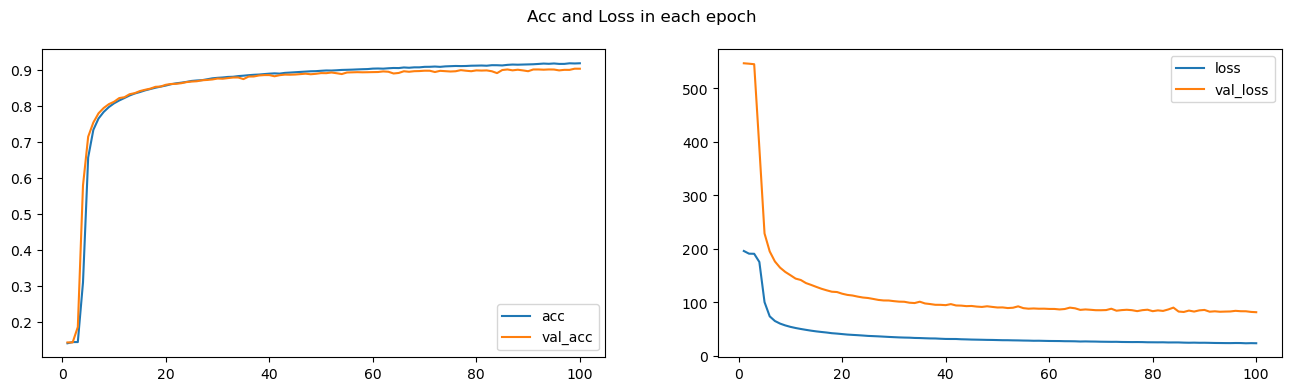

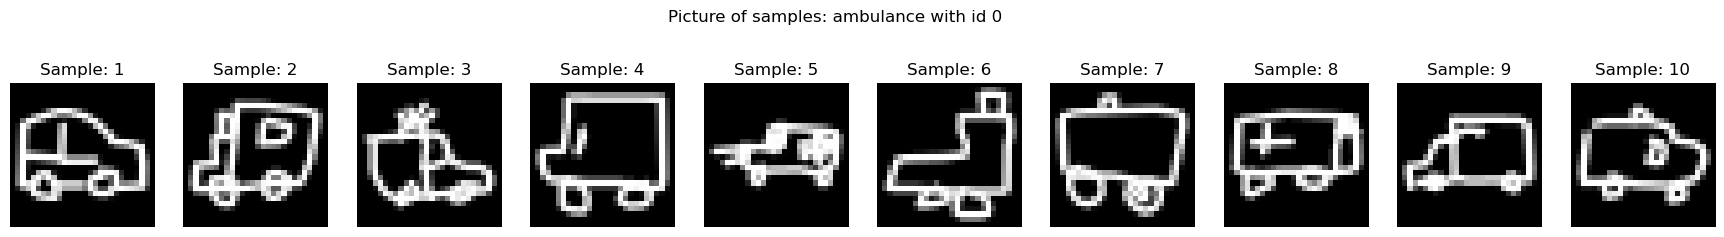

/var/folders/dm/cmsrk78d5nj0z9l_9zyb6yjc0000gn/T/ipykernel_93947/138739319.py:47: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0, 1, 0.1)


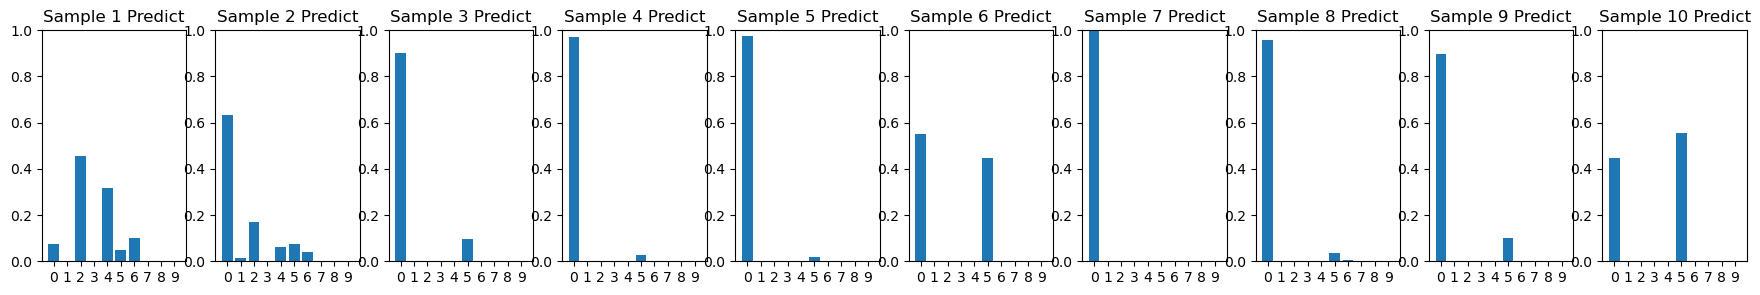

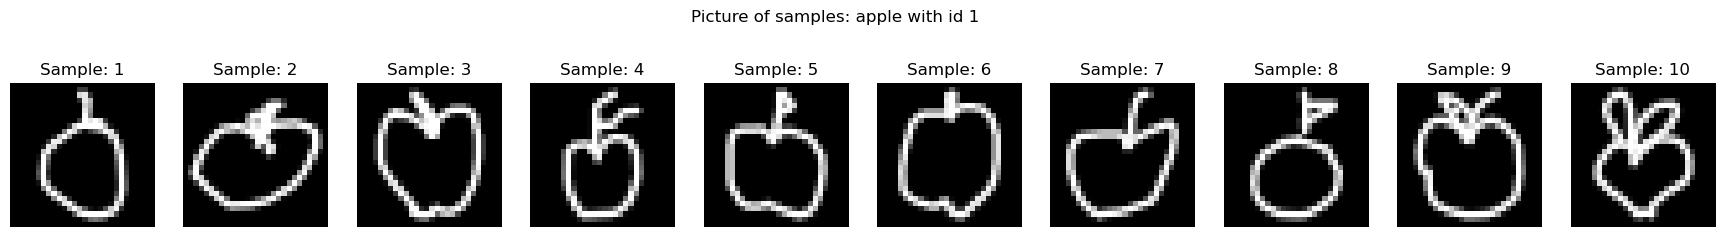

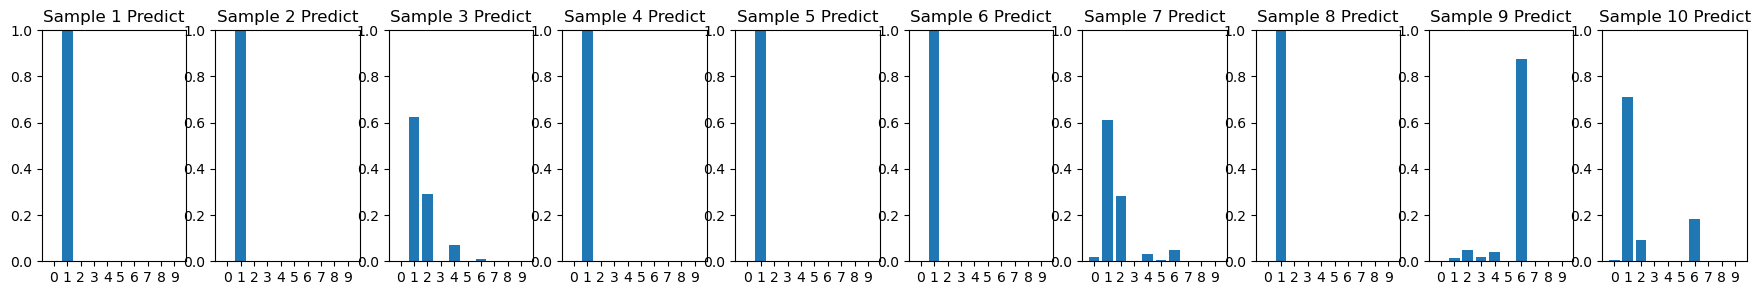

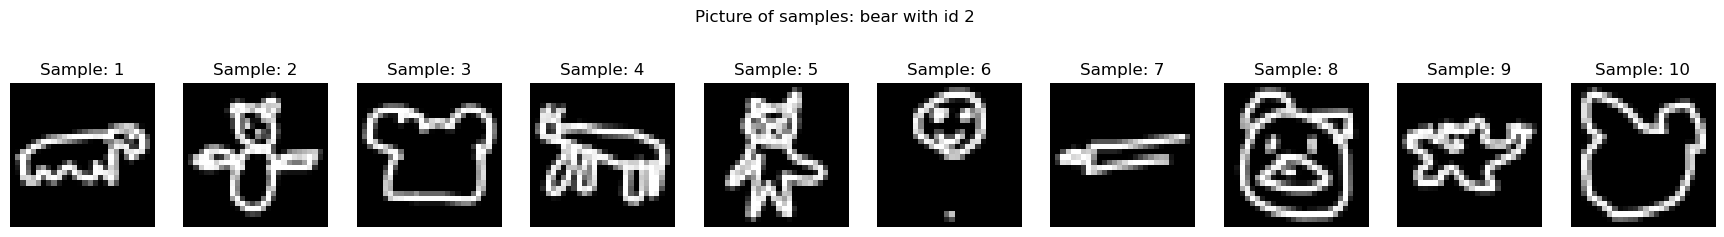

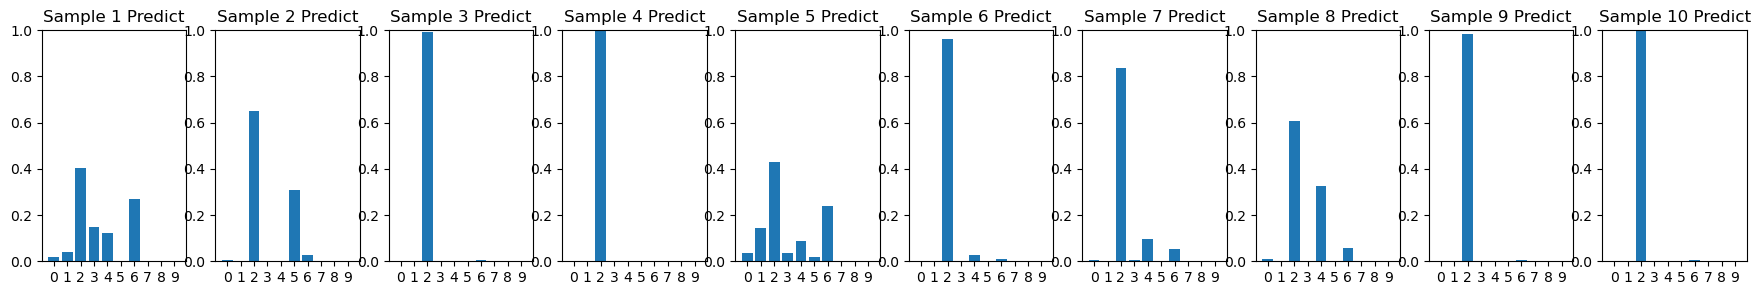

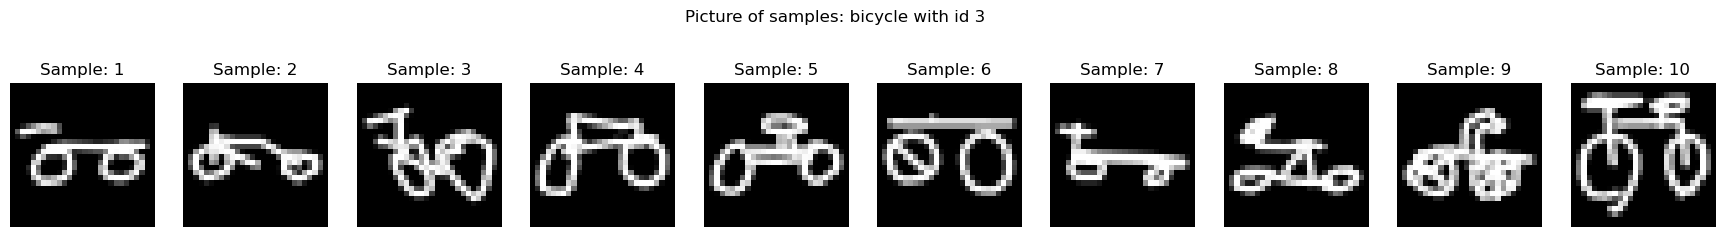

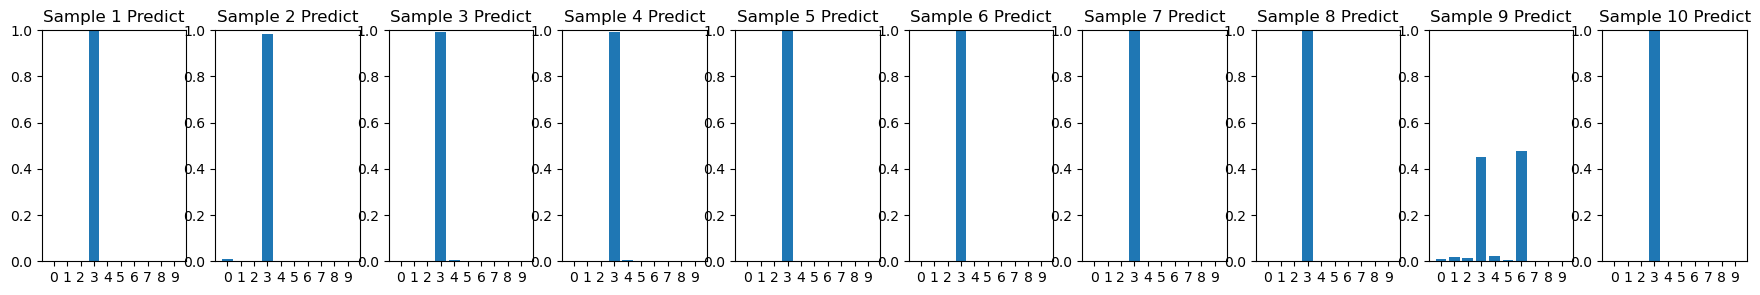

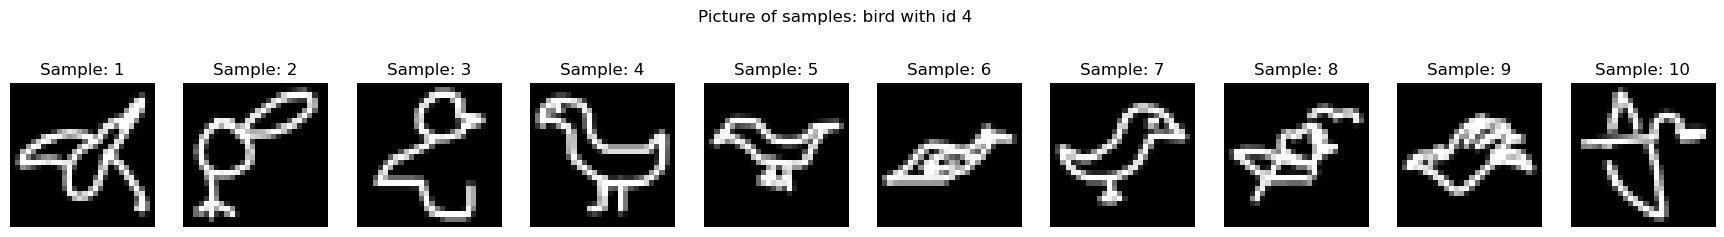

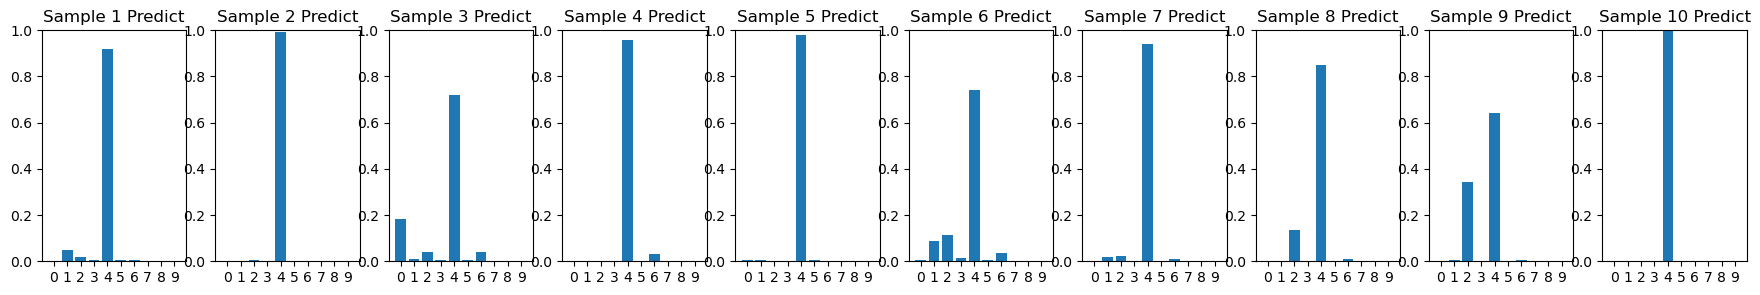

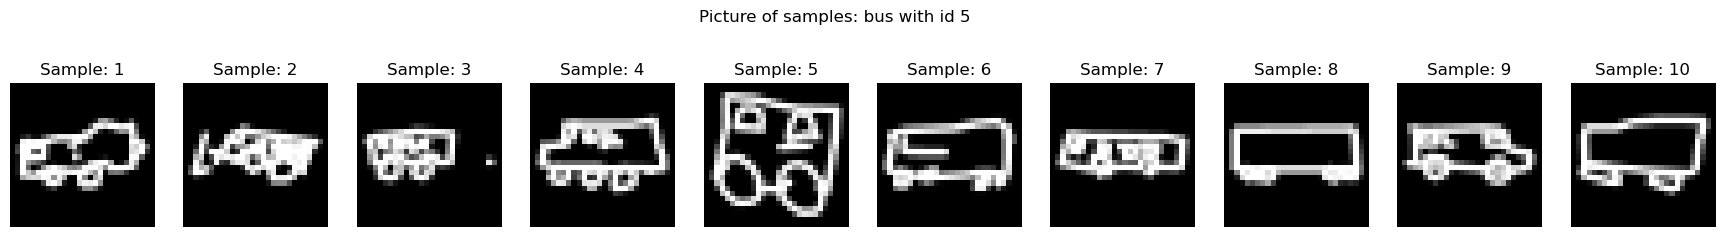

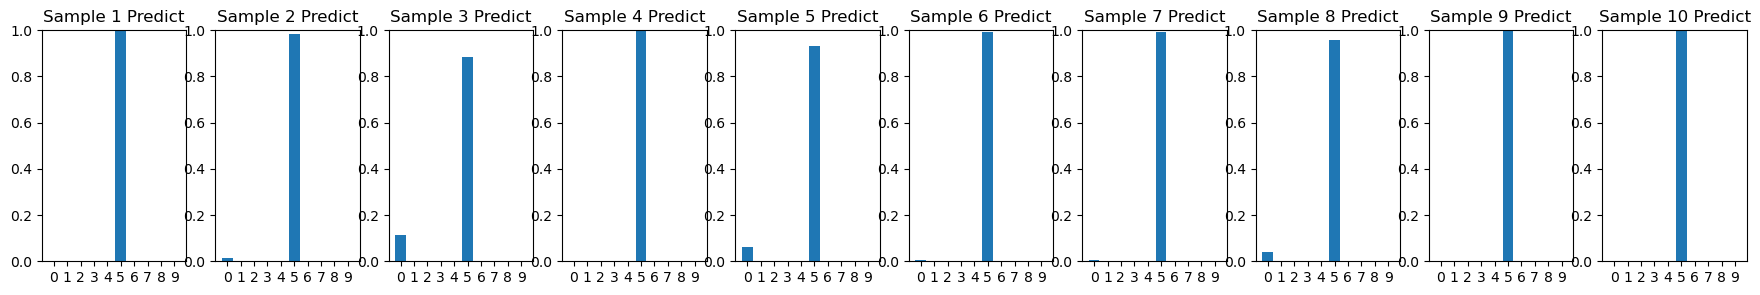

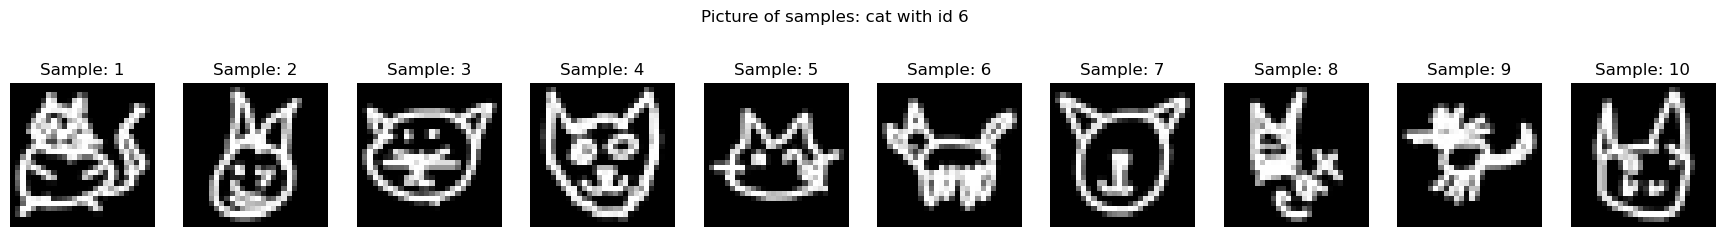

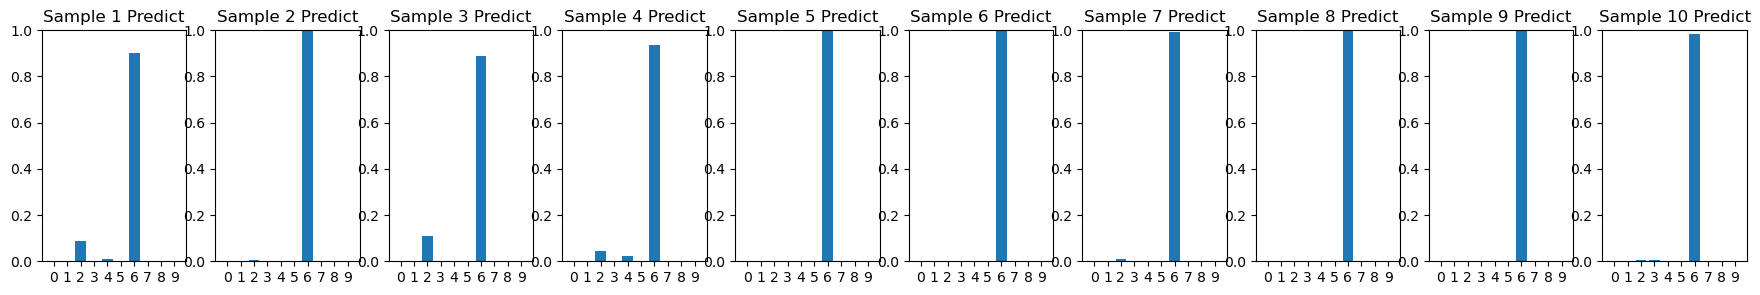

in data acc:0.901


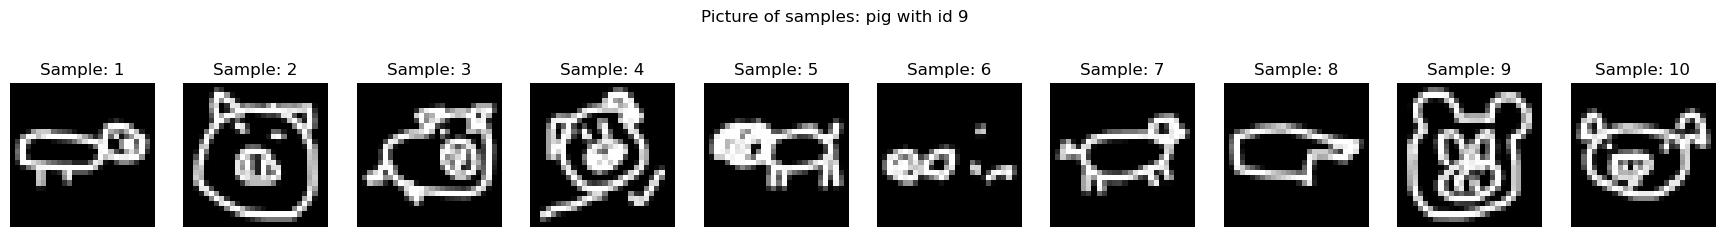

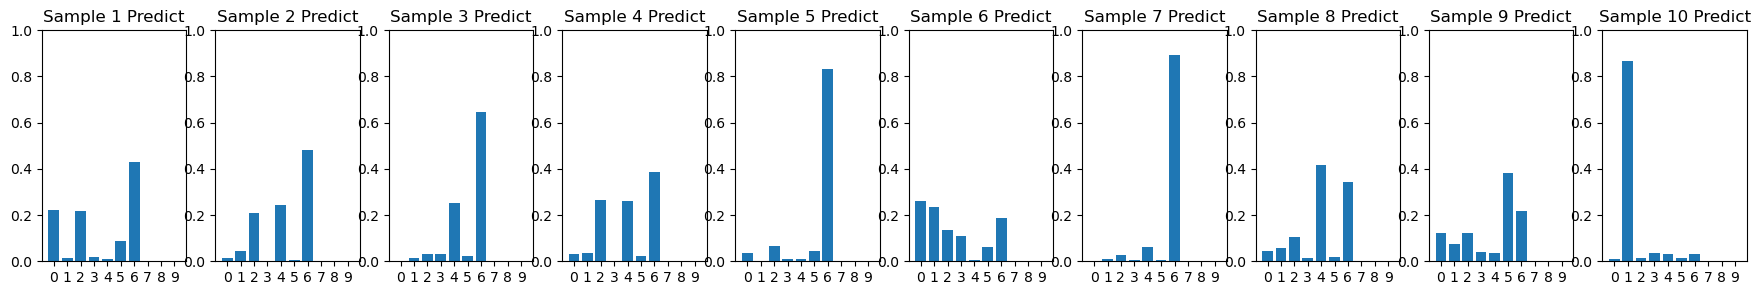

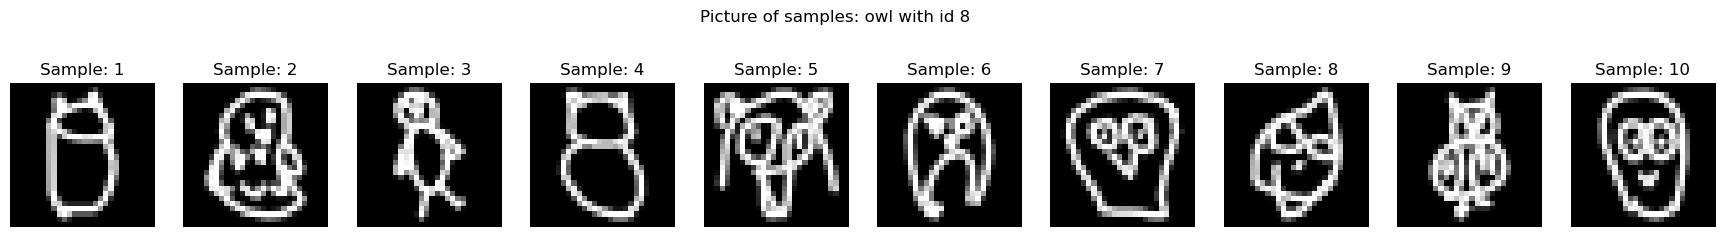

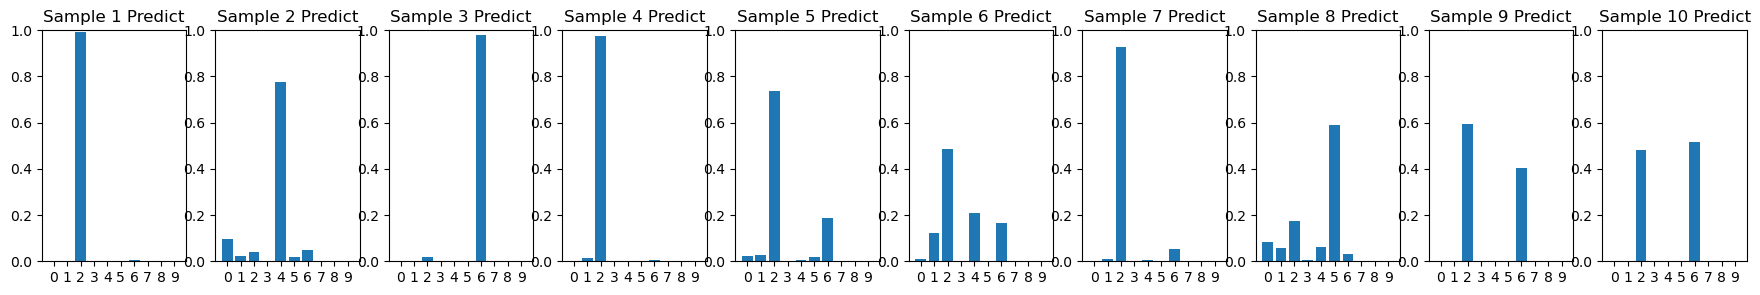

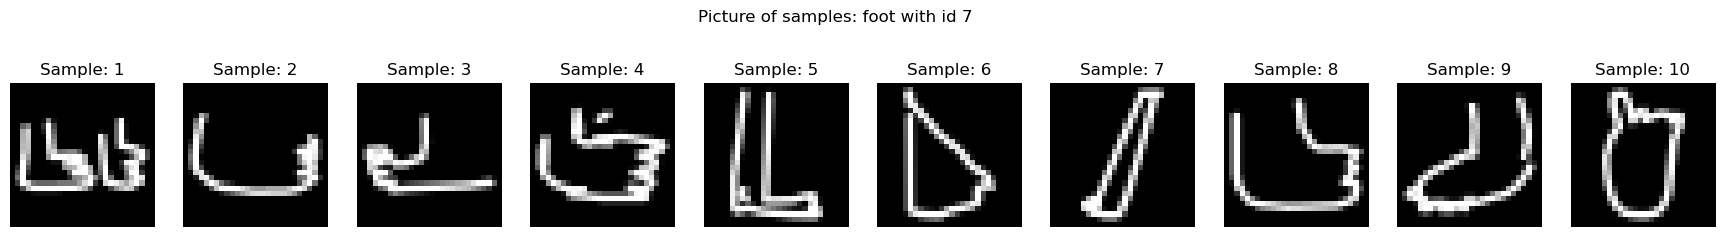

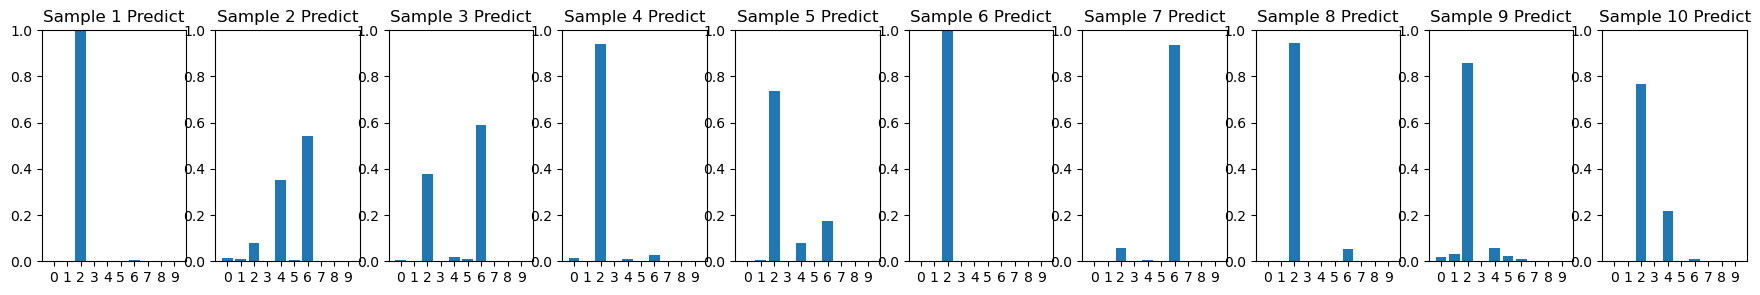

out data acc:0.000


In [19]:
model_l = LeNet()
device = torch.device("mps")
epochs = 100

# 模型训练
train(model_l, device, learning_rate=0.001, num_epochs=epochs, batch_size=1000, train_data=train_data, val_data=val_data)

# 加载模型
trained_model =LeNet()
trained_model.load_state_dict(torch.load(f'./trained_LeNet_model_{epochs}epochs.pth'))

# 模型测试
model_test(trained_model, device, test_data_in, 'in')
model_test(trained_model, device, test_data_out, 'out')



### 1.3.2 GoogleLeNet训练

该模型过于复杂，故而使用其他机器中的3090进行了训练，直接打印截图

该模型过于复杂，mps训练速度也太慢，故而使用其他机器中的3090进行了训练，直接打印训练截图


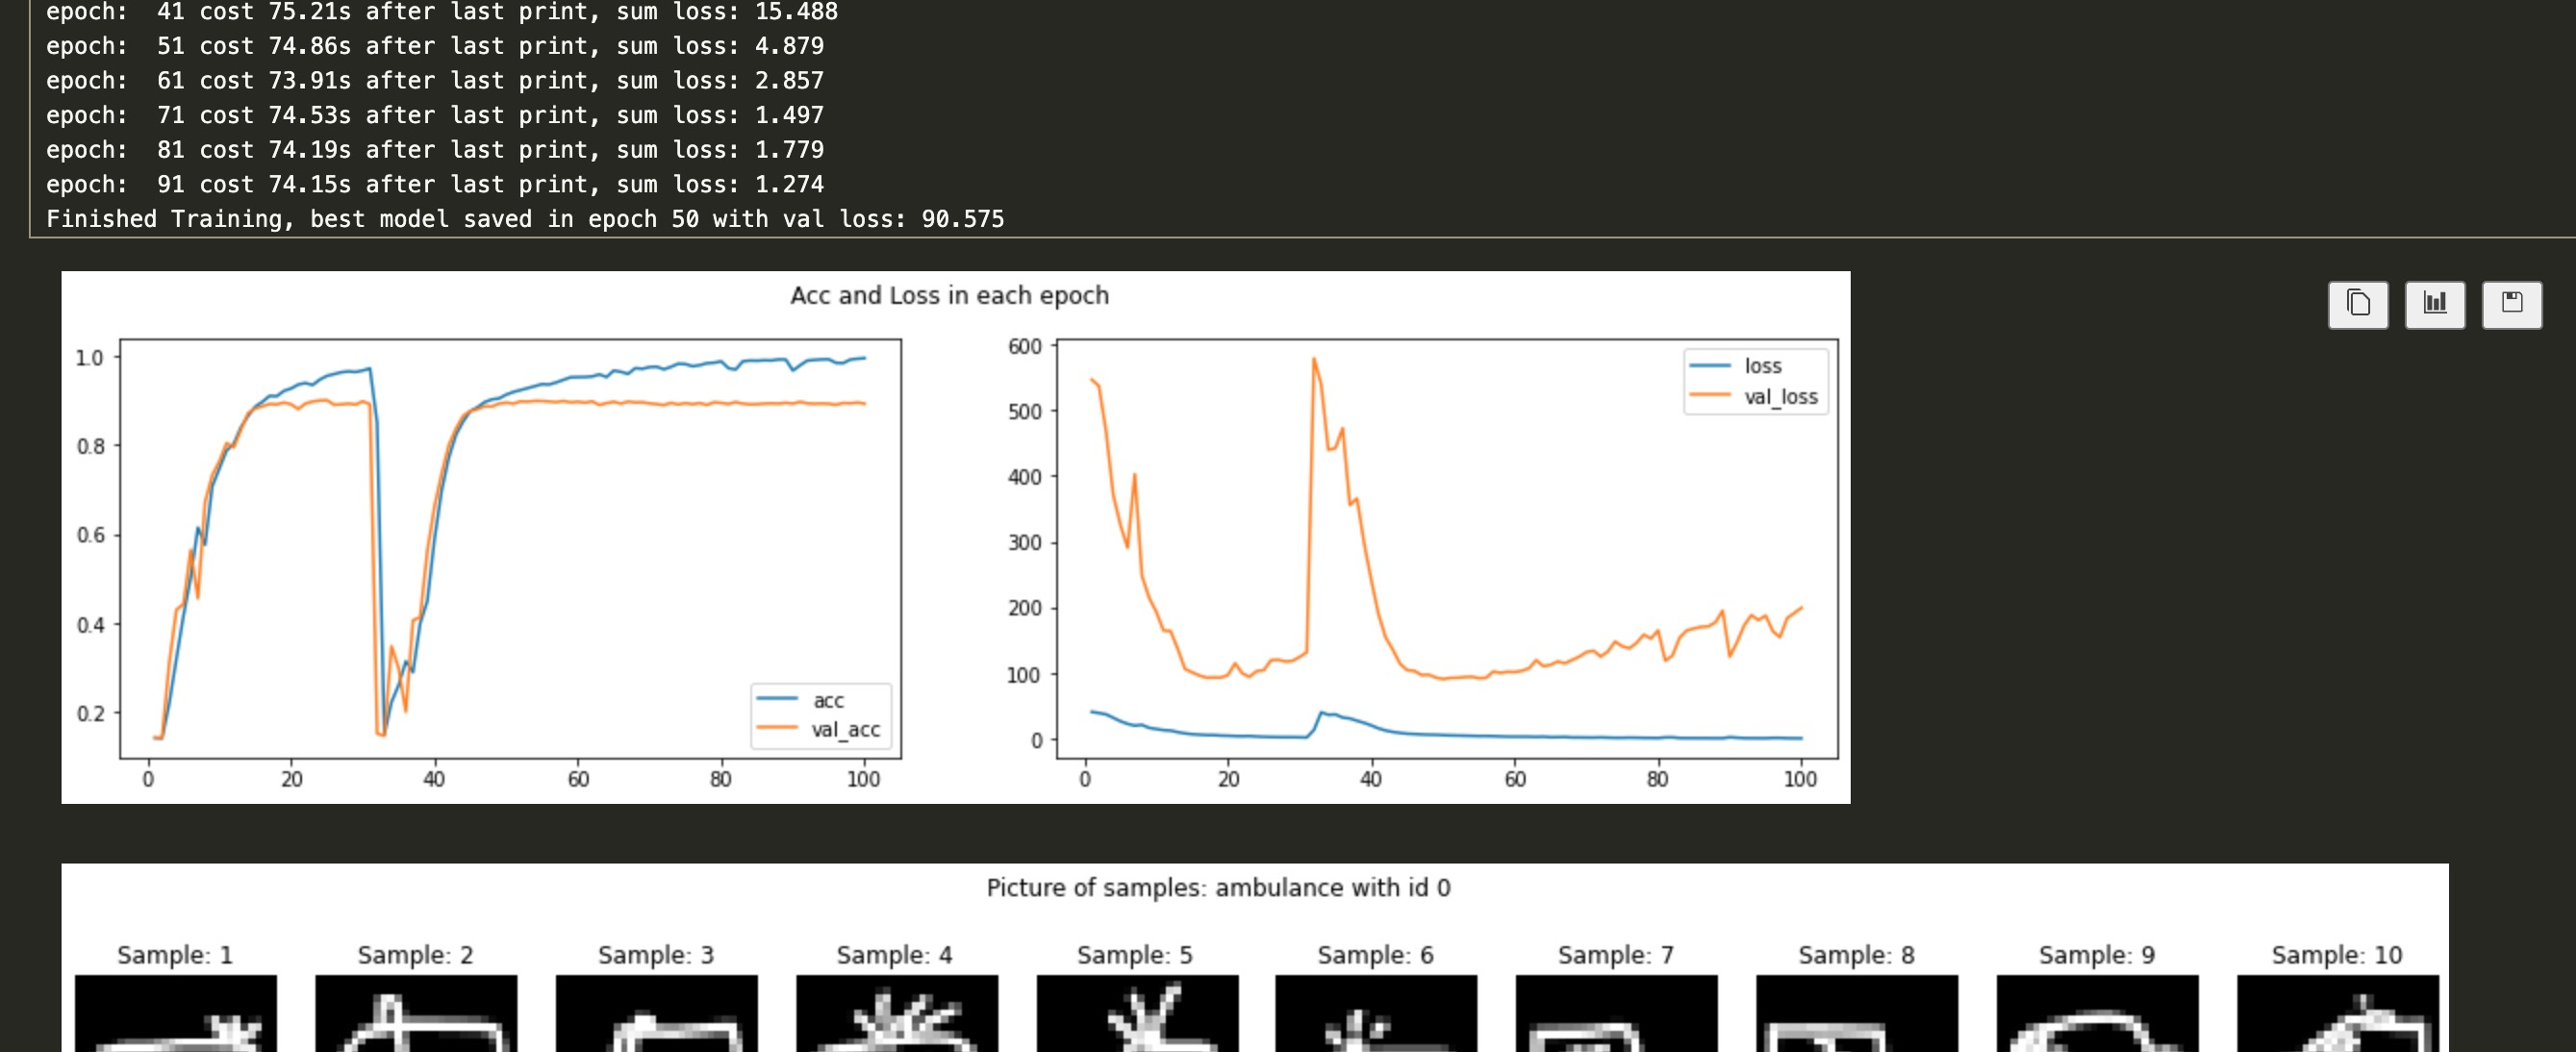

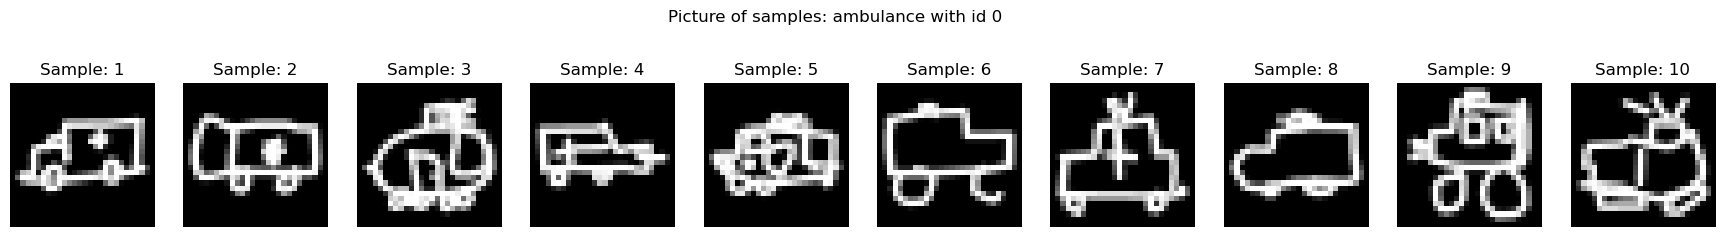

/var/folders/dm/cmsrk78d5nj0z9l_9zyb6yjc0000gn/T/ipykernel_93947/138739319.py:47: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0, 1, 0.1)


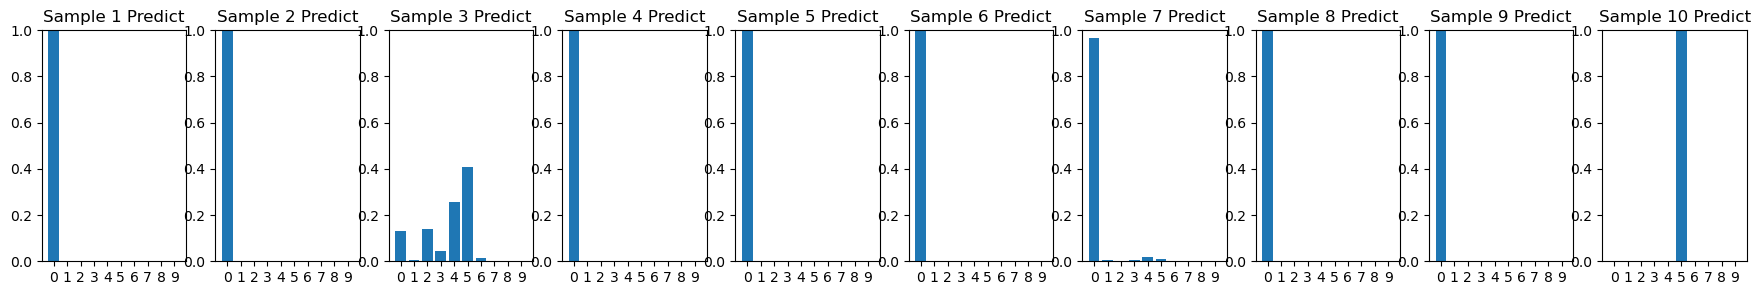

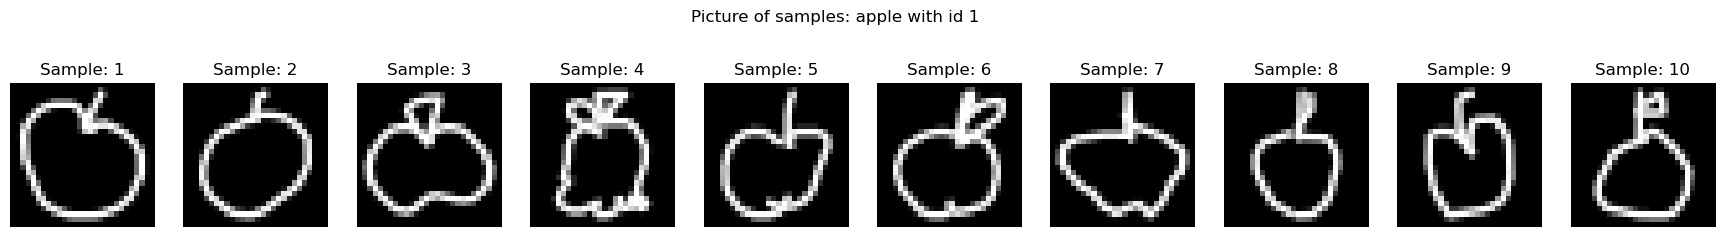

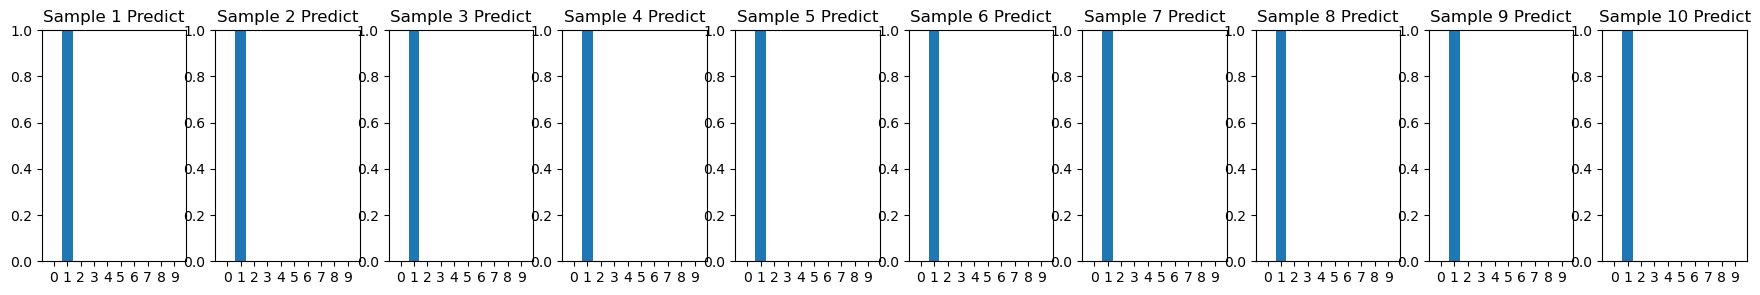

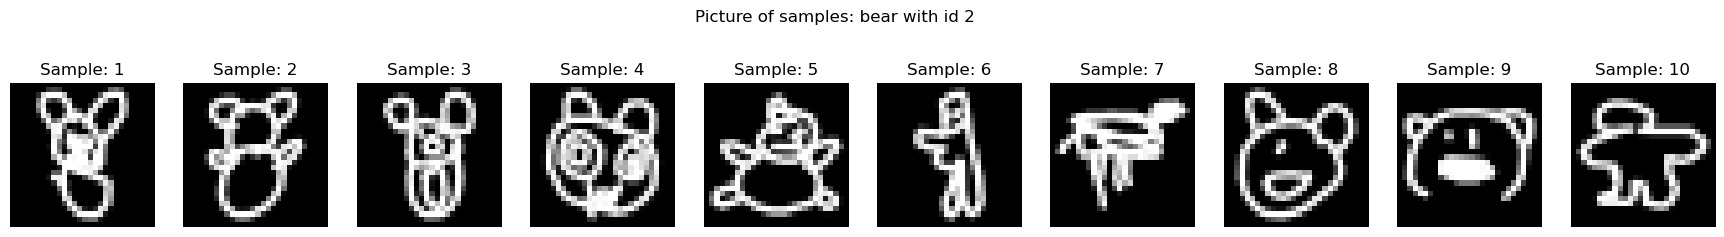

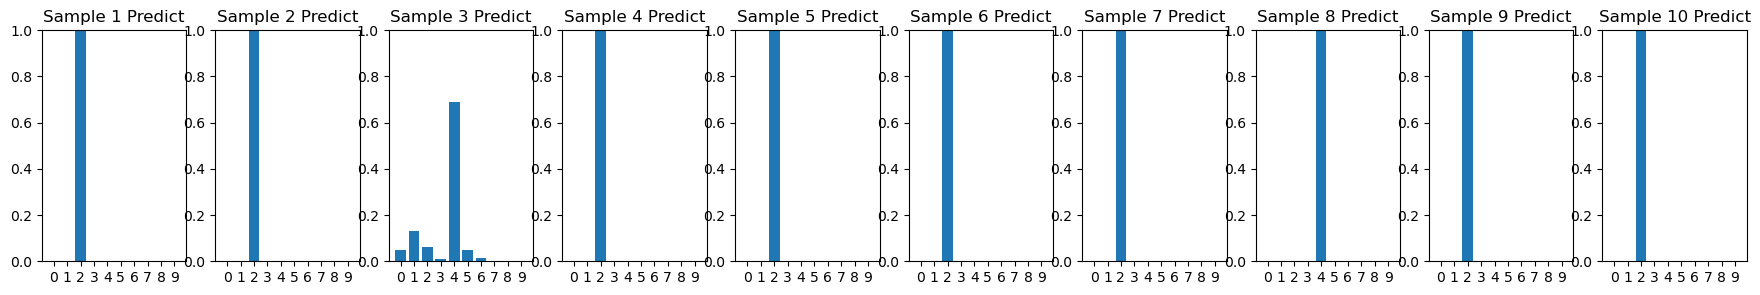

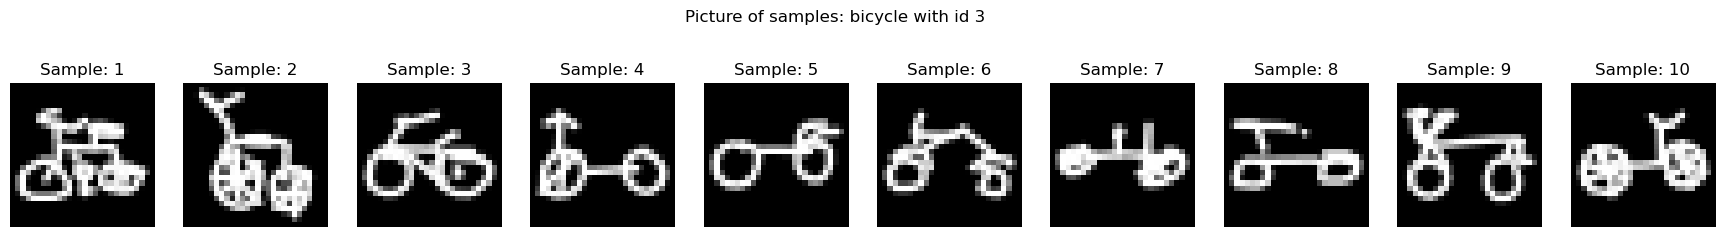

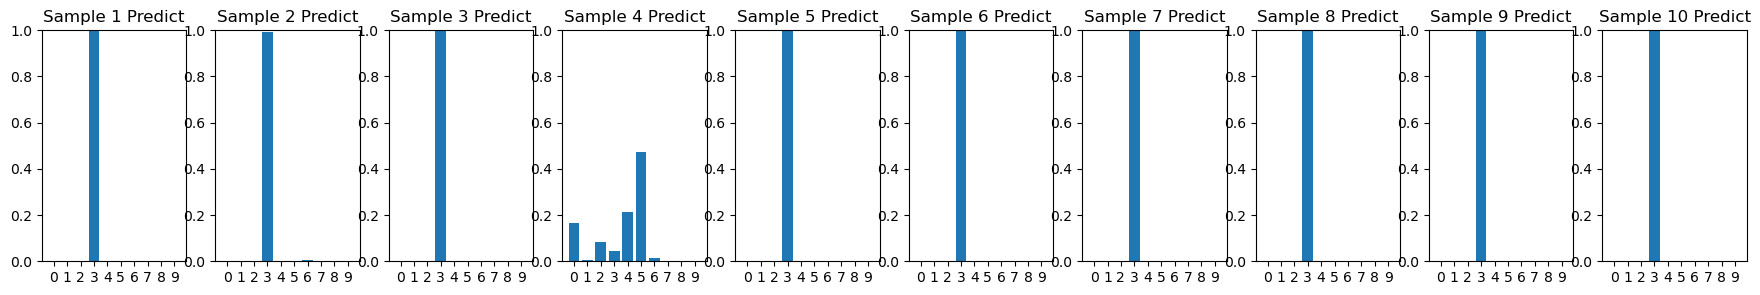

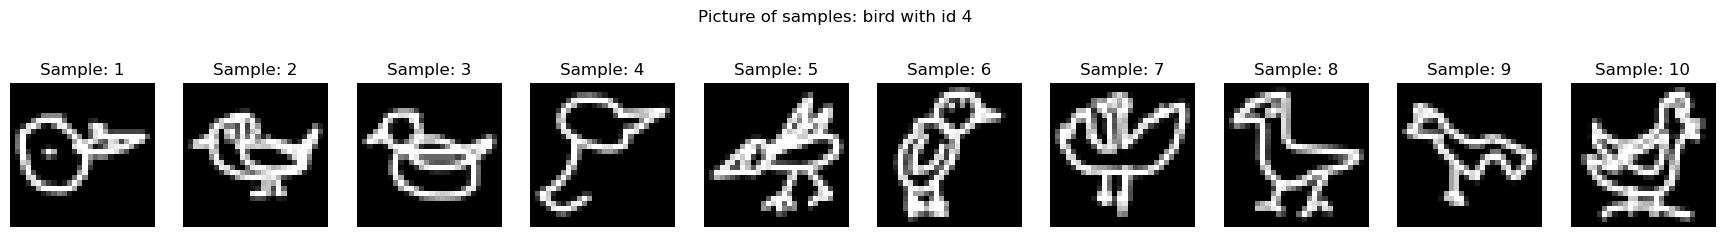

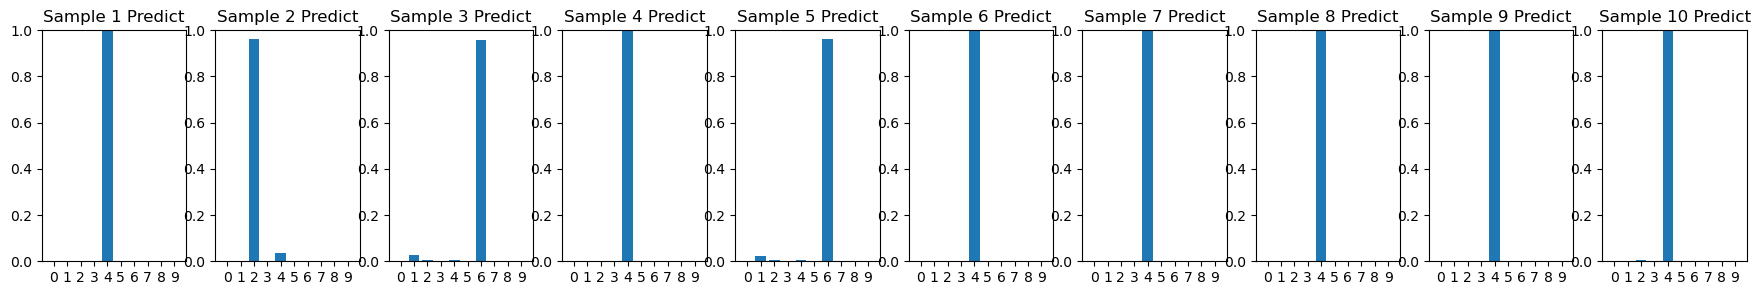

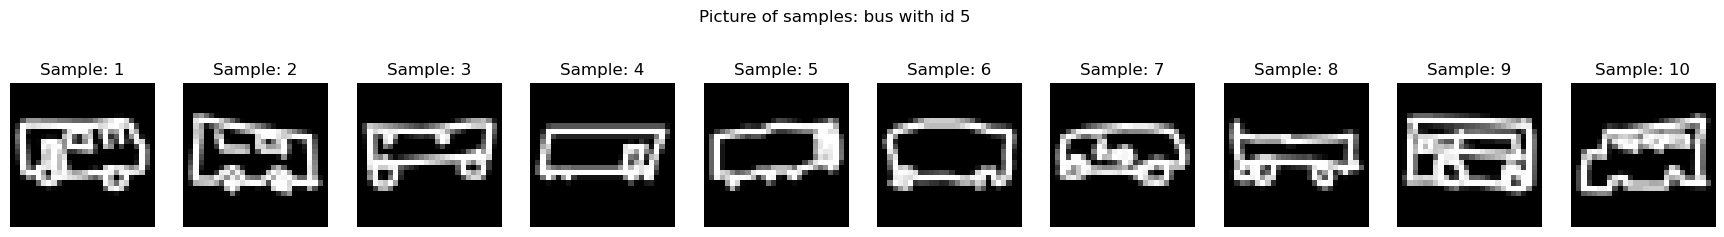

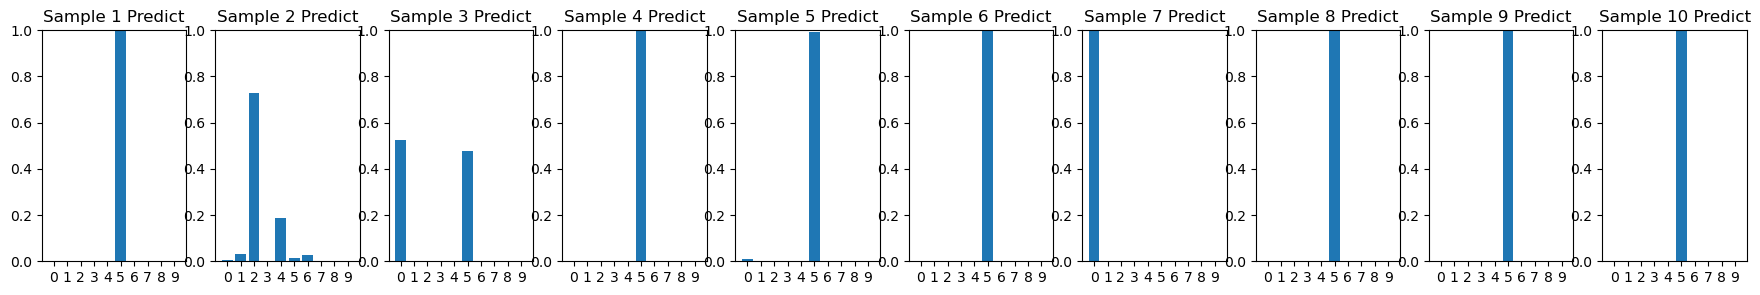

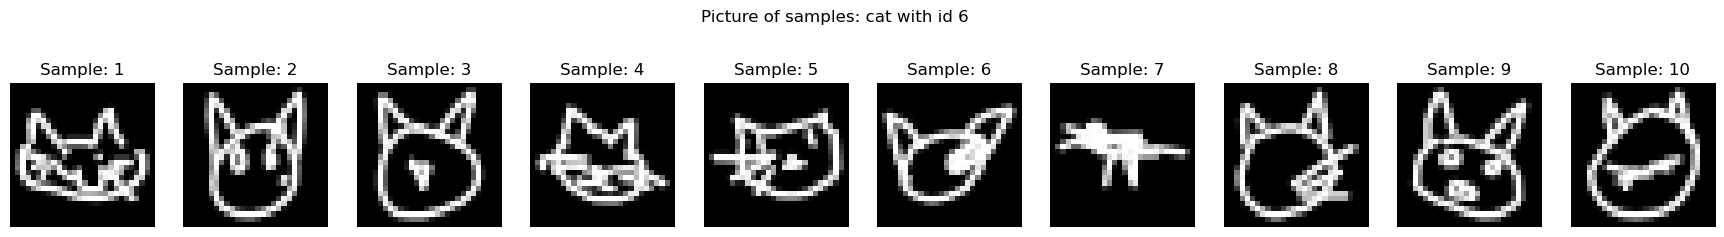

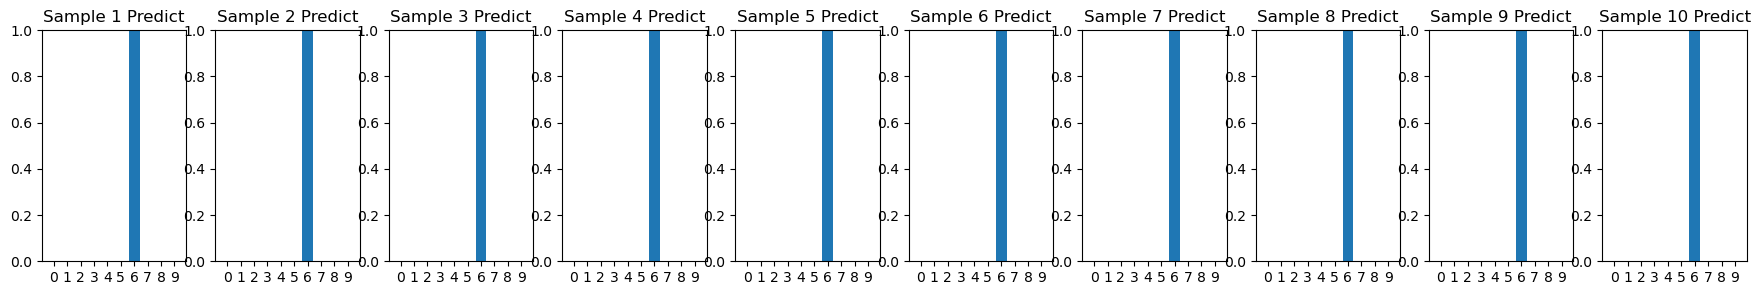

in data acc:0.886


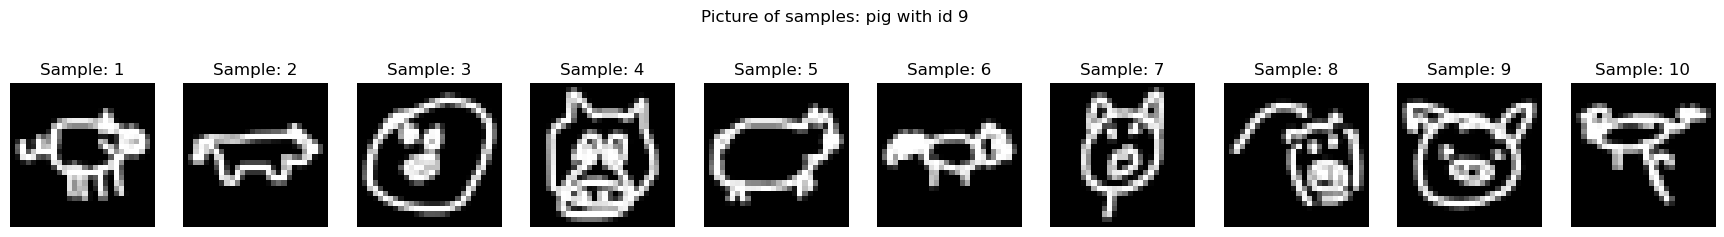

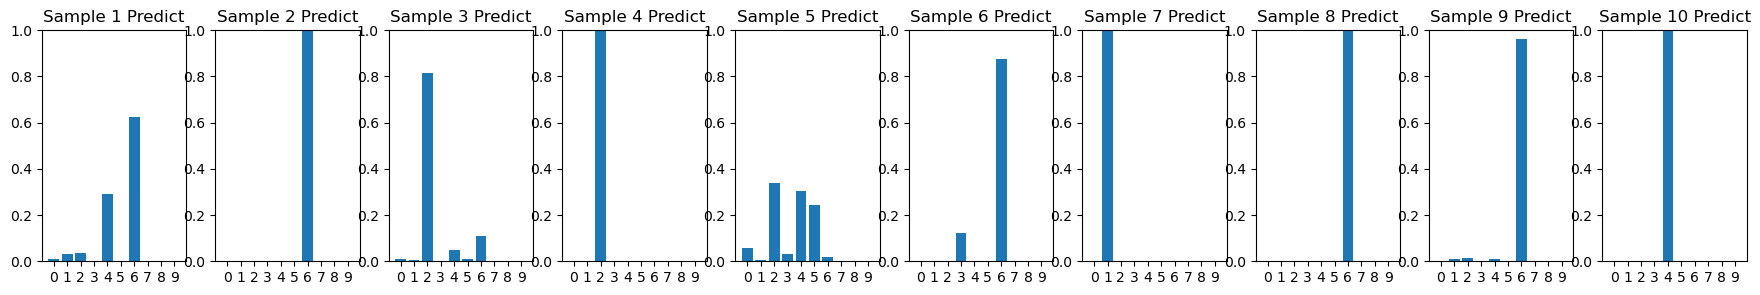

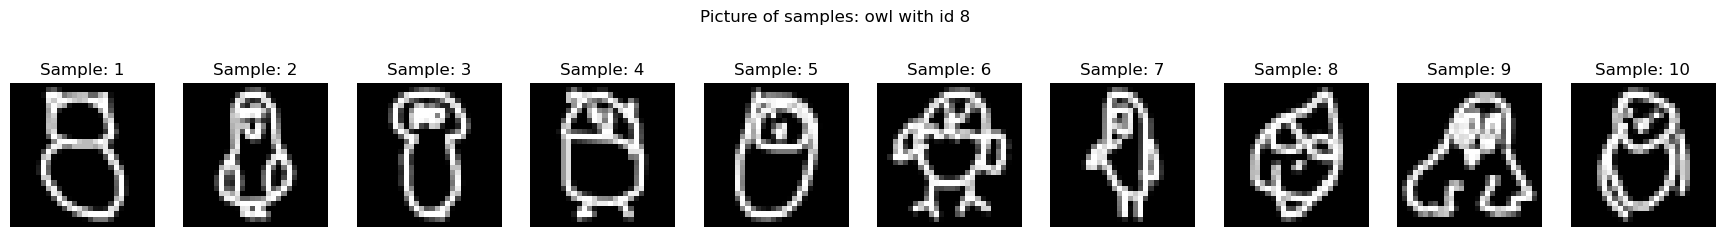

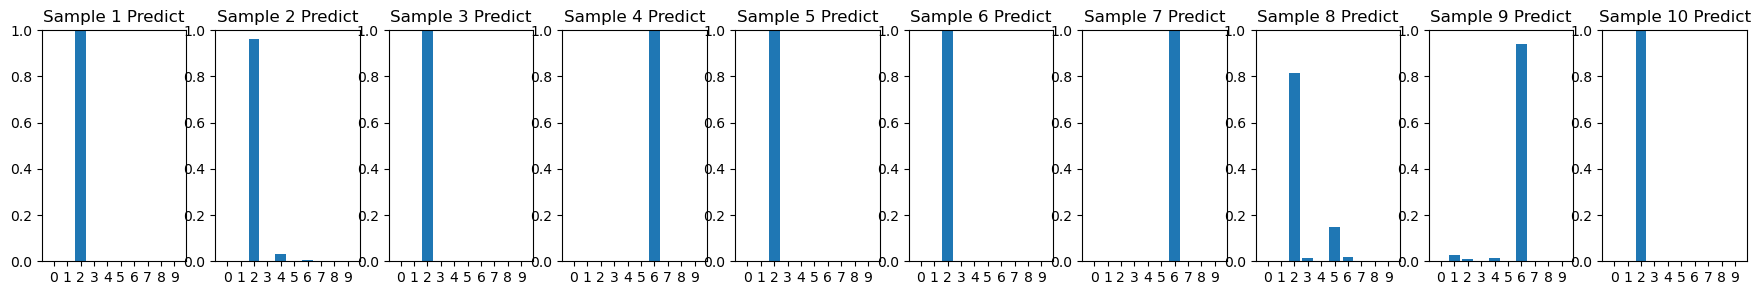

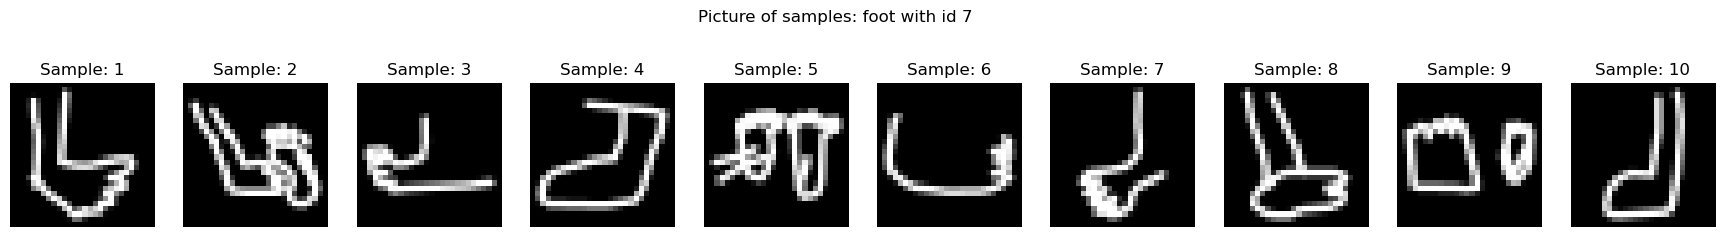

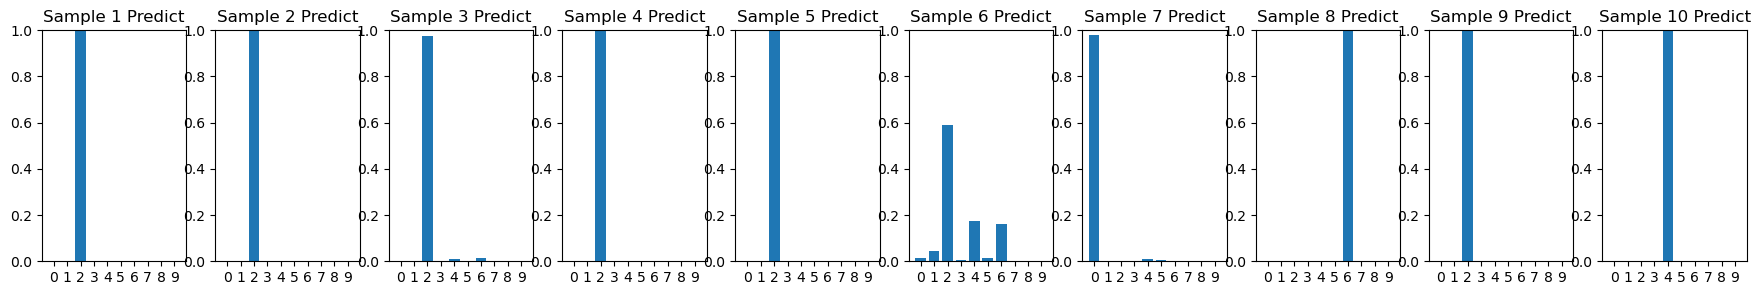

out data acc:0.000


In [20]:
from IPython.display import display
from IPython.display import Image

model_g = GoogleLeNet()
device = torch.device("mps") # 实际上速度过慢，不使用
epochs = 100

# 模型训练
# train(model_g, device, learning_rate=0.001, num_epochs=epochs, batch_size=1000, train_data=train_data, val_data=val_data)

print("该模型过于复杂，mps训练速度也太慢，故而使用其他机器中的3090进行了训练，直接打印训练截图")
train_img_path = './Snipaste_2023-11-03_18-39-53.jpg'
display(Image(filename=train_img_path))



# 加载模型
trained_model =GoogleLeNet()
trained_model.load_state_dict(torch.load(f'./trained_GoogleLeNet_model_{epochs}epochs.pth', map_location=torch.device('mps')))

# 模型测试
model_test(trained_model, device, test_data_in, 'in')
model_test(trained_model, device, test_data_out, 'out')

## 1.4 结果分析
1. 在训练区间内，两个模型都有良好的效果，更简单的LeNet模型在训练集上的准确率反而更高；
2. 在训练区间外，两个模型都不具有预测能力，并且通过概率分布图可以看出，模型几乎不认为有图片有概率属于789这个三个区间外的类别；
3. 两个模型在100个epoch的情况下都没有过拟合的现象；
4. GoogleLeNet模型的训练时间更长，训练过程中出现了意义不明的loss剧烈波动，且在训练集上的准确率更低，未能发现GoogleLeNet模型的优势。
